# Galileo SSI

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from scipy.stats import linregress

from scipy.optimize import curve_fit

from ssi import SSI

In [27]:
#img = SSI('C0416073100R_cal.pho.cub', offset_l=8)
#img = SSI('C0368976678R_cal.pho.cub')
#img = SSI('C0552809352R_cal.pho.cub')
#img = SSI('C0401727726R_cal.pho.cub')
#img = SSI('C0413743200R_cal.pho.cub')
#img = SSI('C0639063413R_cal.pho.cub')
#img = SSI('C0413743222R_cal.pho.cub') #pointing vector issue couldn't be solved using the normal solution phase = 27
img = SSI('C0413743245R_cal.pho.cub',offset_l=-28, offset_s=85) #pointing vector issue couldn't be solved using the normal solution
#img = SSI('C0360063926R_cal.pho.cub')
#img = SSI('C0360063913R_cal.pho.cub')
#img = SSI('C0401727700R_cal.pho.cub') #new disc image
#img = SSI('5126r_cal_crop.pho.cub') #new disc image
img

<SSI> Cube: C0413743245R_cal
 - Size: (400, 400)
 - Start time: 1997-09-19 12:40:37.133000
 - Filter name: IR-9680
 - Exposure: 0.39583 seconds
 - Main target: EUROPA
 - Data alignment: (85, -28)

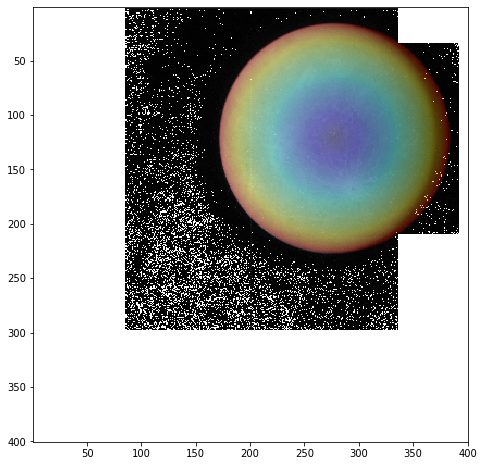

In [28]:
plt.figure(figsize=(8, 8))

plt.imshow(img.data, cmap='gray', extent=img.extent)
plt.imshow(img.emi, cmap='jet', extent=img.extent, alpha=.3)

#plt.xlim(550, 700)
#plt.ylim(250, 50);

## Get a single pixel

Pixels are defined between `1` and `NS`, and, `1` and `NL`:

In [141]:
img[150, 300]  # [Sample, Line]

<SSIPixel> C0416073100R_cal-S150_L300
 - Sample: 150
 - Line: 300
 - I/F: nan
 - Lon: nan°W
 - Lat: nan°N
 - Inc: nan°
 - Emi: nan°
 - Phase: nan°
 - Res: nan km/pix

## Image planes

All the planes layers are:

In [142]:
img.layers

['CLEAR',
 'Phase Angle',
 'Emission Angle',
 'Incidence Angle',
 'Latitude',
 'Longitude']

All the images planes are accessibles with the following convension:

```python
VIOLET|CLEAR|… => data
Latitude => lon
Longitude => lat
Incidence Angle => inc
Emission Angle => emi
Phase Angle => phase
cos(inc) => mu0
cos(emi) => mu1
```

In [110]:
img.data

array([[0.0315705 ,        nan, 0.00531236, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)

To extract the data, use array index, ie.:

In [111]:
img.data[150:152, 290:300]  # [1:NS, 1:NL]

array([[nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan]], dtype=float32)

In [112]:
img.emi[400:402, 300:305]  # Same [Sample, Line]

array([[nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan]], dtype=float32)

To get a single line:

In [113]:
img.inc[:, 150].shape

(800,)

Filter by an array condition:

In [114]:
img.inc.min(), img.inc.max()

(nan, nan)

In [115]:
img.phase.min(), img.phase.max()


(nan, nan)

In [116]:
cond = ~np.isnan(img.phase)
np.max(img.phase[cond])


172.93774

In [117]:
#plt.imshow(img.phase, extent=img.extent)
#plt.colorbar();
#np.arange(2.00, 2.5, .1)

In [118]:
cond = ~np.isnan(img.emi)
np.max(img.emi[cond])

89.61263

In [119]:
cond = ~np.isnan(img.inc)
np.max(img.inc[cond])

179.32672

## Image miss-alignement

In some cases, we obseved some pointing issue with the camera compare to the actual data:

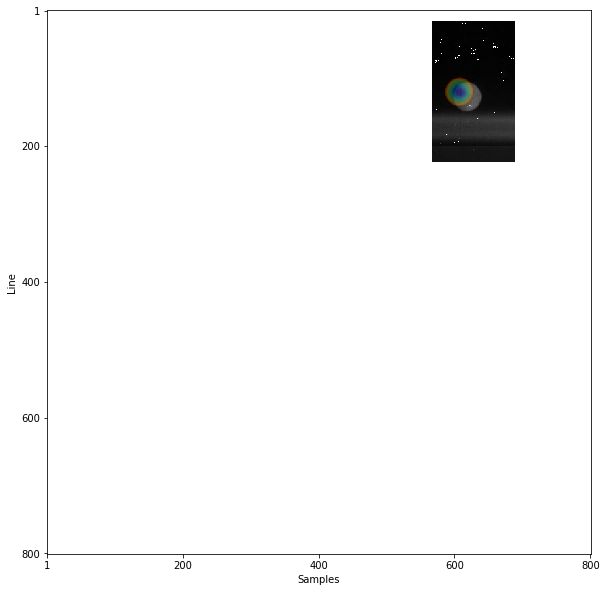

In [143]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.imshow(img.data, cmap='gray', extent=img.extent)
ax.imshow(img.emi, cmap='jet', extent=img.extent, alpha=.3)

ax.set_xlabel('Samples')
ax.set_ylabel('Line')
ax.set_xticks(img.sticks)
ax.set_yticks(img.lticks);

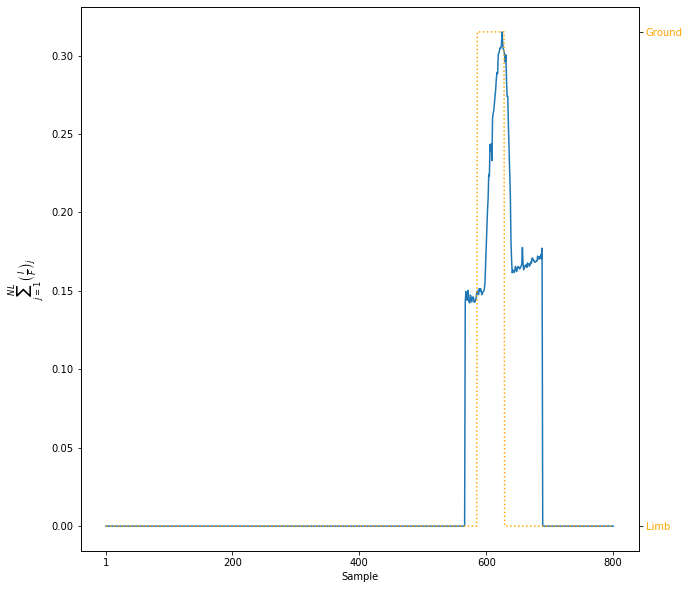

In [144]:
fig, ax0 = plt.subplots(1, 1, figsize=(10, 10))
ax1 = ax0.twinx()

ax0.plot(img.s, np.nansum(img.data, axis=0))
ax1.plot(img.s, np.nansum(img.ground, axis=0) > 0, color='orange', ls=':')

ax0.set_xticks(img.sticks)
ax1.set_yticks([0, 1])
ax1.set_yticklabels(['Limb', 'Ground'], color='orange')

ax0.set_xlabel('Sample')
ax0.set_ylabel(r'$\sum_{j=1}^{NL} \left(\frac{I}{F}\right)_j$', fontsize=12);

To calculate the offset of the navigation data compare to the `I/F` data, we use a [`numpy.correlate`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.correlate.html) (see `ssi.align.corr_offset`).
The function `alignement()` allow the user to search for offset in sample and line direction and store the results in the `offset` attribute.

In [145]:
img.alignment()
img.offset

(13, 52)

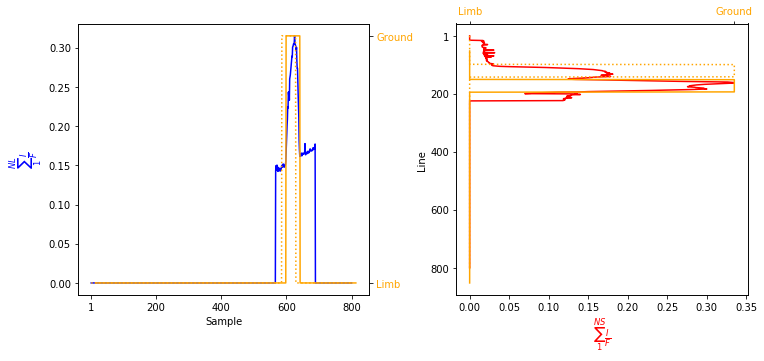

In [146]:
offset_s, offset_l = img.alignment()  # Store offset alignment values
img.alignment(False)                  # Disable alignement

fig, (ax0, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plt.subplots_adjust(wspace=.3)

ax1 = ax0.twinx()
ax3 = ax2.twiny()

ax0.plot(img.s, np.nansum(img.data, axis=0), 'b')
ax1.plot(img.s, np.nansum(img.ground, axis=0) > 0, color='orange', ls=':')
ax1.plot(img.s + offset_s, np.nansum(img.ground, axis=0) > 0, color='orange')

ax2.plot(np.nansum(img.data, axis=1), img.l, 'r')
ax3.plot(np.nansum(img.ground, axis=1) > 0, img.l, color='orange', ls=':')
ax3.plot(np.nansum(img.ground, axis=1) > 0, img.l + offset_l, color='orange')

ax0.set_xticks(img.sticks)
ax1.set_yticks([])
ax1.set_yticks([0, 1])
ax1.set_yticklabels(['Limb', 'Ground'], color='orange')

ax2.set_yticks(img.lticks)
ax3.set_xticks([0, 1])
ax3.set_xticklabels(['Limb', 'Ground'], color='orange')
ax2.invert_yaxis()
ax3.invert_yaxis()

ax0.set_xlabel('Sample')
ax0.set_ylabel(r'$\sum_{1}^{NL} \frac{I}{F}$', fontsize=12, color='blue')

ax2.set_ylabel('Line')
ax2.set_xlabel(r'$\sum_{1}^{NS} \frac{I}{F}$', fontsize=12, color='red');

If the alignement is enable, the navigation planes are automatically offset to take this change into account:

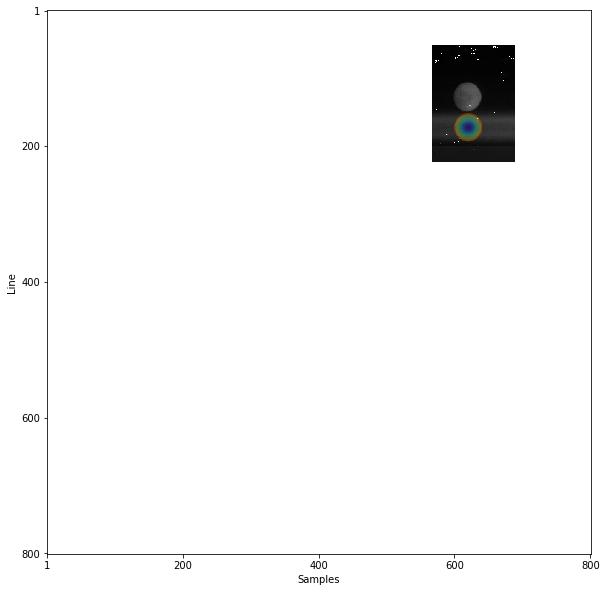

In [147]:
img.alignment(True)  # Align navigation data and I/F data

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.imshow(img.data, cmap='gray', extent=img.extent)
ax.imshow(img.emi, cmap='jet', extent=img.extent, alpha=.3)

ax.set_xlabel('Samples')
ax.set_ylabel('Line')
ax.set_xticks(img.sticks)
ax.set_yticks(img.lticks);

We can see that the pixels navigation information are also shitted accordingly to the offset:

In [148]:
img.alignment(False)
print(repr(img[200, 600]), '\n')

img.alignment(True)
print(repr(img[200, 600]))

<SSIPixel> C0416073100R_cal-S200_L600
 - Sample: 200
 - Line: 600
 - I/F: nan
 - Lon: nan°W
 - Lat: nan°N
 - Inc: nan°
 - Emi: nan°
 - Phase: nan°
 - Res: nan km/pix 

<SSIPixel> C0416073100R_cal-S200_L600
 - Sample: 200
 - Line: 600
 - I/F: nan
 - Lon: nan°W
 - Lat: nan°N
 - Inc: nan°
 - Emi: nan°
 - Phase: nan°
 - Res: nan km/pix


## Fit SSI data

In [29]:
L = 150
i_f = img.data[:, L]
inc = img.inc[:, L]
emi = img.emi[:, L]
mu0 = img.mu0[:, L]
mu1 = img.mu1[:, L]


#S = 300
#i_f = img.data[:, S]
#inc = img.inc[:, S]
#emi = img.emi[:, S]
#mu0 = img.mu0[:, S]
#mu1 = img.mu1[:, S]

Intensity formula as a function of the incidence and emission angles:

$$ \frac{I}{F} = B_0 \cdot \mu_0 ^ k \cdot \mu_1 ^{k - 1}$$

$$\Rightarrow \ln(\frac{I}{F} \cdot \mu_1) = k \cdot \ln(\mu_0 \cdot \mu_1) + \ln(B_0)$$

In [30]:
xdata = np.log(mu0 * mu1)
ydata = np.log(i_f * mu1)
cond = ~np.isnan(xdata) & ~np.isnan(ydata)

k, lnB0, r_value, p_value, std_err = linregress(xdata[cond], ydata[cond])

f'k: {k:.2e}, B0: {np.exp(lnB0):.2e}, r^2: {r_value**2:.2f}'

C:\Users\rajanidh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


'k: 7.50e-01, B0: 7.31e-01, r^2: 0.99'

In [31]:
#cond = ~np.isnan(xdata) & ~np.isnan(ydata)

#xdata = [mu0, mu1]
#ydata = i_f

#cond = ~np.isnan(xdata) & ~np.isnan(ydata)

#xdata = [mu0, mu1]
#ydata = i_f 

#def func(x, k, B0):
#    """Fitting function"""
#    return B0 * np.power(x[0], k) * np.power(x[1], k-1)

#    f(xdata[cond], 0.7, 1) - i_f

IndentationError: unexpected indent (<ipython-input-31-462fb4ef6bd5>, line 12)

In [32]:
#popt, pcov = curve_fit(func, xdata, ydata)#, bounds=(1,3))

#fig, ax = plt.subplots(1, 2, figsize=(16, 8))

#xlabel = ['Incidence', 'Emission']

#for i in range(2):
#    ax[i].plot(xdata[i], ydata, 'bo', label='Data')
#    ax[i].plot(xdata[i], func(xdata, *popt), 'r-', label='fit: k=%5.3f, B_0=%5.3f' % tuple(popt))

#    ax[i].legend()

#    ax[i].set_xlabel(xlabel[i])
#    ax[i].set_ylabel('I/F');

In [33]:
x = np.linspace(np.nanmin(xdata), np.nanmax(xdata))
y = k * x + lnB0

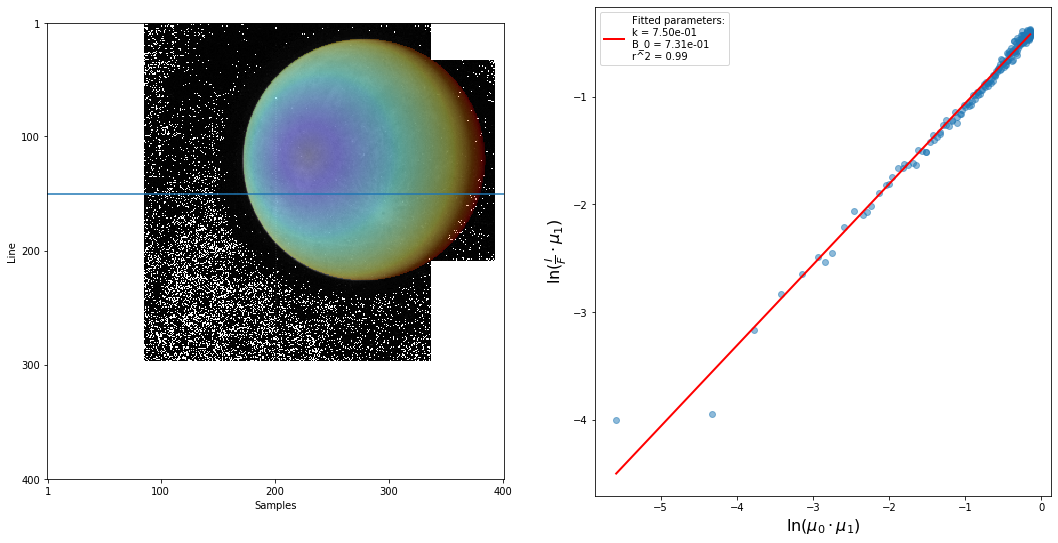

In [36]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(18, 9))

ax0.imshow(img.data, cmap='gray', extent=img.extent)
ax0.imshow(img.inc, cmap='jet', extent=img.extent, alpha=.3)
ax0.axhline(L)
#ax0.axvline(S)

ax0.set_xlabel('Samples')
ax0.set_ylabel('Line')
ax0.set_xticks(img.sticks)
ax0.set_yticks(img.lticks)

ax1.scatter(xdata, ydata, alpha=.5)
ax1.plot(x, y, 'r-', lw=2, label=f'Fitted parameters:\nk = {k:.2e}\nB_0 = {np.exp(lnB0):.2e}\nr^2 = {r_value**2:.2f}')
ax1.set_xlabel(r'$\ln(\mu_0 \cdot \mu_1)$', fontsize=16)
ax1.set_ylabel(r'$\ln(\frac{I}{F} \cdot \mu_1)$', fontsize=16)
ax1.legend();